In [2]:
import json

# Load both datasets and collect pairIDs
eval_pairs = set()
with open('hans/heuristics_evaluation_set.jsonl', 'r') as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            eval_pairs.add(data['pairID'])

train_pairs = set()
with open('hans/heuristics_train_set.jsonl', 'r') as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            train_pairs.add(data['pairID'])

# Check for overlaps
overlap = eval_pairs.intersection(train_pairs)
print(f'Eval set size: {len(eval_pairs)}')
print(f'Train set size: {len(train_pairs)}')
print(f'Overlap count: {len(overlap)}')

Eval set size: 30000
Train set size: 30000
Overlap count: 30000


In [3]:
#Loading actual datasets to verify no overlaps in content

eval_examples = {}
with open('hans/heuristics_evaluation_set.jsonl', 'r') as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            eval_examples[data['pairID']] = {
                'sentence1': data['sentence1'],
                'sentence2': data['sentence2'],
                'gold_label': data['gold_label'],
                'heuristic': data['heuristic'],
                'subcase': data['subcase']
            }

train_examples = {}
with open('hans/heuristics_train_set.jsonl', 'r') as f:
    for line in f:
        if line.strip():
            data = json.loads(line)
            train_examples[data['pairID']] = {
                'sentence1': data['sentence1'],
                'sentence2': data['sentence2'],
                'gold_label': data['gold_label'],
                'heuristic': data['heuristic'],
                'subcase': data['subcase']
            }

print(f"Loaded {len(eval_examples)} eval examples and {len(train_examples)} train examples")

Loaded 30000 eval examples and 30000 train examples


In [10]:
# Check all overlapping IDs
all_overlap_ids = list(eval_pairs.intersection(train_pairs))
total_identical = 0
total_checked = 0
remotely_similar = 0

for pair_id in all_overlap_ids:
    if pair_id in eval_examples and pair_id in train_examples:
        eval_ex = eval_examples[pair_id]
        train_ex = train_examples[pair_id]
        
        is_identical = (
            eval_ex['sentence1'] == train_ex['sentence1'] and
            eval_ex['sentence2'] == train_ex['sentence2'] and
            eval_ex['gold_label'] == train_ex['gold_label']
        )

        is_similar = (
            eval_ex['sentence1'] == train_ex['sentence1'] and
            eval_ex['sentence2'] == train_ex['sentence2']
        )

        is_remotely_similar = (
            eval_ex['sentence1'] == train_ex['sentence1'] or
            eval_ex['sentence2'] == train_ex['sentence2'] or 
            eval_ex['sentence1'] == train_ex['sentence2'] or
            eval_ex['sentence2'] == train_ex['sentence1']
        )
        
        if is_identical:
            total_identical += 1
        if is_similar and not is_identical:
            print(f"Similar but not identical for pairID {pair_id}:")
            print(f"Eval: {eval_ex}")
            print(f"Train: {train_ex}")
        if is_remotely_similar and not is_similar:
            print(f"Remotely similar for pairID {pair_id}:")
            print(f"Eval: {eval_ex}")
            print(f"Train: {train_ex}")
            remotely_similar += 1
        total_checked += 1

print(f'Total overlapping pairIDs: {len(all_overlap_ids)}')
print(f'Checked: {total_checked}')
print(f'Identical examples: {total_identical}')
print(f'Percentage identical: {100 * total_identical / total_checked:.2f}%')

print("Total is_remotely_similar examples found:", remotely_similar)

Remotely similar for pairID ex26204:
Eval: {'sentence1': 'Before the lawyer advised the authors , the scientists performed .', 'sentence2': 'The scientists performed .', 'gold_label': 'entailment', 'heuristic': 'constituent', 'subcase': 'ce_after_since_clause'}
Train: {'sentence1': 'Since the bankers thanked the student , the scientists performed .', 'sentence2': 'The scientists performed .', 'gold_label': 'entailment', 'heuristic': 'constituent', 'subcase': 'ce_after_since_clause'}
Remotely similar for pairID ex28391:
Eval: {'sentence1': 'The artist slept , and the tourists introduced the professors .', 'sentence2': 'The artist slept .', 'gold_label': 'entailment', 'heuristic': 'constituent', 'subcase': 'ce_conjunction'}
Train: {'sentence1': 'The actor advised the students , and the artist slept .', 'sentence2': 'The artist slept .', 'gold_label': 'entailment', 'heuristic': 'constituent', 'subcase': 'ce_conjunction'}
Remotely similar for pairID ex648:
Eval: {'sentence1': 'The judge re

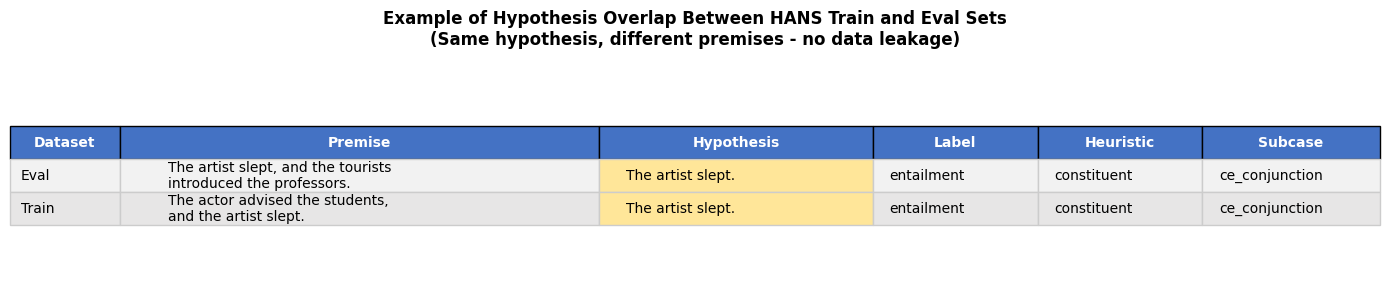

✓ Figure saved as 'hans_overlap_example.png'


In [15]:
#creating matplotlib table visualizing one result of the is_remotely_similar examples found
import matplotlib.pyplot as plt
import pandas as pd


data = {'Eval': {'sentence1': 'The artist slept , and the tourists introduced the professors .',
                  'sentence2': 'The artist slept .', 'gold_label': 'entailment',
                    'heuristic': 'constituent', 'subcase': 'ce_conjunction'},
'Train': {'sentence1': 'The actor advised the students , and the artist slept .',
           'sentence2': 'The artist slept .', 'gold_label': 'entailment',
             'heuristic': 'constituent', 'subcase': 'ce_conjunction'}}

df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.2)
plt.show()

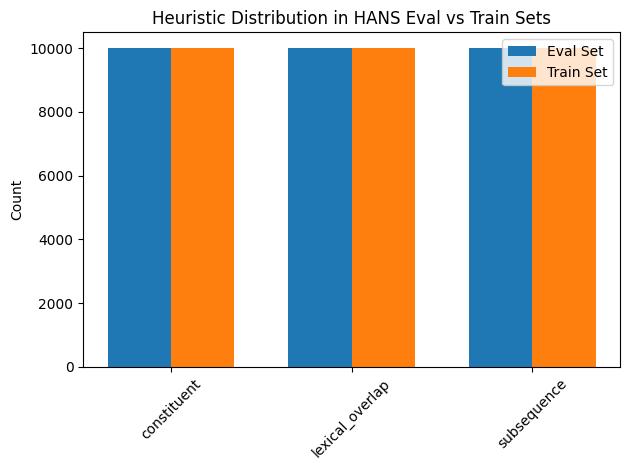

In [8]:
#creating bar char to show distribution of heuristics in eval set vs train set
from collections import Counter
import matplotlib.pyplot as plt

eval_heuristics = [data['heuristic'] for data in eval_examples.values()]
train_heuristics = [data['heuristic'] for data in train_examples.values()]

eval_counts = Counter(eval_heuristics)
train_counts = Counter(train_heuristics)

labels = list(set(eval_counts.keys()).union(set(train_counts.keys())))
eval_values = [eval_counts.get(label, 0) for label in labels]
train_values = [train_counts.get(label, 0) for label in labels]

x = range(len(labels))
width = 0.35
fig, ax = plt.subplots()
ax.bar(x, eval_values, width, label='Eval Set')
ax.bar([p + width for p in x], train_values, width, label='Train Set') 
ax.set_ylabel('Count')
ax.set_title('Heuristic Distribution in HANS Eval vs Train Sets')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()